In [1]:
import time
import math
from tqdm.auto import tqdm
from tqdm.utils import _term_move_up

prefix = _term_move_up() + '\r'

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from data import DrawingDataset
from customModel import customModel, EarlyStopper

%load_ext autoreload
%autoreload 2

2024-03-09 00:45:05.916104: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 00:45:06.567102: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_properties(0))

True
NVIDIA GeForce GTX 1080
_CudaDeviceProperties(name='NVIDIA GeForce GTX 1080', major=6, minor=1, total_memory=8110MB, multi_processor_count=20)


In [3]:
batch_size = 256
max_length = 100

train_dataset = DrawingDataset(data_path="./data", split="train", max_length=max_length)
val_dataset = DrawingDataset(data_path="./data", split="valid", max_length=max_length)
test_dataset = DrawingDataset(data_path="./data", split="test", max_length=max_length)

train = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

['./data/cat.npz', './data/sailboat.npz', './data/marker.npz', './data/headphones.npz', './data/airplane.npz']


100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


['./data/cat.npz', './data/sailboat.npz', './data/marker.npz', './data/headphones.npz', './data/airplane.npz']


100%|██████████| 5/5 [00:00<00:00, 70.30it/s]


['./data/cat.npz', './data/sailboat.npz', './data/marker.npz', './data/headphones.npz', './data/airplane.npz']


100%|██████████| 5/5 [00:00<00:00, 66.03it/s]


In [4]:
log_interval = 25
epochs = 20

batches = len(train)

model = customModel(nb=4, no=2, ns=2, embed_dim=256).to("cuda")

offset_crit = nn.MSELoss(reduction='none')
state_crit = nn.CrossEntropyLoss()

#optimizer = torch.optim.RAdam(model.parameters(), lr=5e-4)
#warmup_ratio = 0.03s

print(0.05 * math.sqrt(batch_size / (batches * epochs)))
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr=1e-3, betas=(0.99, 0.95), eps=1e-4,
                              weight_decay=0.05 * math.sqrt(batch_size / (batches * epochs)))   
# scheduler = get_cosine_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps=1,
#                                             num_training_steps=epochs)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, 
                                                       T_max=epochs, eta_min=1e-5)

writer = SummaryWriter('./logs/100_seq')

def train_model(model, data_loader, optimizer, epoch):
    model.train()
    
    size = len(data_loader)
    
    # Total Losses
    total_loss = 0
    total_offset_loss = 0
    total_state_loss = 0
    
    # Running Losses
    running_loss = 0
    running_offset_loss = 0
    running_state_loss = 0
    
    running_correct = 0
    running_total = 0
    
    running_mse = 0
    
    start_time = time.time()
    
    for i, data in enumerate(tqdm(data_loader)):
        optimizer.zero_grad()
        
        inputs, targets = data
        inputs = inputs.to("cuda")
        targets = targets.to("cuda")
        
        offsets, states = model(inputs)
        
        # Split Target
        offset_target = targets[:, :, :2]
        state_target = targets[:, :, 2:].argmax(dim=-1)
        no_pad_mask = state_target != 2
        
        # Masked MSE Loss for offset
        offset_loss = offset_crit(offsets, offset_target)
        offset_loss_mask = offset_loss * no_pad_mask.unsqueeze(-1).float()
        
        offset_loss = offset_loss_mask.sum() / no_pad_mask.sum()
        
        # Cross Entropy Loss for State
        state_loss = state_crit(states.transpose(1, 2), state_target)
        loss = offset_loss + state_loss
        
        # Calculate other metrics (accuracy)
        with torch.no_grad():
            states_softmax = torch.nn.functional.softmax(states, dim=-1)
            states_pred = states_softmax.argmax(dim=-1)
            
            no_pad_mask = state_target.flatten() != 2

            running_correct += (states_pred.flatten()[no_pad_mask] == state_target.flatten()[no_pad_mask]).sum().item()
            running_total += states_pred.flatten()[no_pad_mask].size().numel()
            
            flat_offsets_pred = offsets.reshape(-1, 2)[no_pad_mask, :]
            flat_offset_target = targets[:, :, :2].reshape(-1, 2)[no_pad_mask, :]
            running_mse += nn.functional.mse_loss(flat_offsets_pred, flat_offset_target)
        
        # Backprop
        loss.backward(retain_graph=True)
        
        # Gradient Clipping
        for name, param in model.named_parameters():
            torch.nn.utils.clip_grad_norm_(param, max_norm=1.5)
        
        # Optimizer Steps
        optimizer.step()
        
        running_loss += loss.item()
        running_offset_loss += offset_loss.item()
        running_state_loss += state_loss.item()
        
        total_loss += loss.item()
        total_offset_loss += offset_loss.item()
        total_state_loss += state_loss.item()
        
        # Print speed, losses, and accuracy every 25 batchs
        if i % log_interval == 0 and i > 0:
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = running_loss / log_interval
            cur_offset_loss = running_offset_loss / log_interval
            cur_state_loss = running_state_loss / log_interval
            cur_accuracy = running_correct / running_total
            cur_mse = running_mse / log_interval
            tqdm.write(f'{prefix}| epoch {(epoch+1):3d} | {i:5d}/{size:5d} batches '
                  f'| ms/batch {ms_per_batch:5.2f} | '
                  f'offset_loss {cur_offset_loss/2:5.2f} | state_loss {cur_state_loss:5.4f} | '
                  f'accuracy {cur_accuracy:5.4f} | mse {cur_mse:5.2f}')
            time.sleep(0)
            running_loss = 0
            running_offset_loss = 0
            running_state_loss = 0
            running_correct = 0
            running_total = 0
            running_mse = 0
            start_time = time.time()
    
    return total_loss / size, total_offset_loss / size, total_state_loss / size
        
def evaluate_model(model, data_loader):
    model.eval()
    size = len(data_loader)
    
    # Running Losses
    running_loss = 0
    running_offset_loss = 0
    running_state_loss = 0
    
    # Correct
    correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in tqdm(data_loader):
            inputs, targets = data
            inputs = inputs.to("cuda")
            targets = targets.to("cuda")
            
            offsets, states = model(inputs)
            
            # Masked MSE Loss
            offset_target = targets[:, :, :2]
            state_target = targets[:, :, 2:].argmax(dim=-1)
            no_pad_mask = state_target != 2
            
            offset_loss = offset_crit(offsets, offset_target)
            offset_loss_mask = offset_loss * no_pad_mask.unsqueeze(-1).float()
            offset_loss = offset_loss_mask.sum() / no_pad_mask.sum()
            
            state_loss = state_crit(states.transpose(1, 2), state_target)
            loss = offset_loss + state_loss
            
            # Accuracy Calculation
            states_softmax = torch.nn.functional.softmax(states, dim=-1)
            states_pred = states_softmax.argmax(dim=-1)
            
            no_pad_mask = no_pad_mask.flatten()
            
            correct += (states_pred.flatten()[no_pad_mask] == state_target.flatten()[no_pad_mask]).sum().item()
            total_samples += states_pred.flatten()[no_pad_mask].size().numel()
            
            running_loss += loss.item()
            running_offset_loss += offset_loss.item()
            running_state_loss += state_loss.item()
    
    return running_loss / size, running_offset_loss / size, running_state_loss / size, correct / total_samples
            


0.004888602220003379


In [5]:
early_stopper = EarlyStopper(patience=3, min_delta=20)
for epoch in range(epochs):
    train_loss, train_offset_loss, train_state_loss = train_model(model, train, optimizer, epoch)
    print(f"Training: Epoch: {epoch+1}, offset_loss: {train_offset_loss/2:5.4f}, state_loss: {train_state_loss:5.4f}")
    writer.add_scalar("Train/Offset_Loss/Epoch", train_offset_loss/2, epoch)
    writer.add_scalar("Train/State_Loss/Epoch", train_state_loss, epoch)
    
    val_loss, val_offset_loss, val_state_loss, val_accuracy = evaluate_model(model, val)
    print(f"Validation: Epoch: {epoch+1}, offset_loss: {val_offset_loss/2:5.2f}, state_loss: {val_state_loss:5.4f}, accuracy: {val_accuracy:5.4f}")
    writer.add_scalar("Validation/Offset_Loss/Epoch", val_offset_loss/2, epoch)
    writer.add_scalar("Validation/State_Loss/Epoch", val_state_loss, epoch)
    writer.add_scalar("Validation/State_Accuracy/Epoch", val_accuracy, epoch)
    
    if early_stopper.early_stop(val_offset_loss):
        break
    
    scheduler.step()

  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch   1 |  1325/ 1339 batches | ms/batch 587.25 | offset_loss 1327.95 | state_loss 0.1452 | accuracy 0.8947 | mse 1327.95
Training: Epoch: 1, offset_loss: 1532.4068, state_loss: 0.1686


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 1, offset_loss: 1196.40, state_loss: 0.1373, accuracy: 0.8963


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch   2 |  1325/ 1339 batches | ms/batch 582.45 | offset_loss 1269.85 | state_loss 0.1395 | accuracy 0.8945 | mse 1269.84
Training: Epoch: 2, offset_loss: 1282.8956, state_loss: 0.1412


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 2, offset_loss: 1125.31, state_loss: 0.1308, accuracy: 0.8998


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch   3 |  1325/ 1339 batches | ms/batch 584.82 | offset_loss 1243.90 | state_loss 0.1343 | accuracy 0.8983 | mse 1243.90
Training: Epoch: 3, offset_loss: 1244.3438, state_loss: 0.1372


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 3, offset_loss: 1112.47, state_loss: 0.1276, accuracy: 0.8985


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch   4 |  1325/ 1339 batches | ms/batch 584.61 | offset_loss 1204.39 | state_loss 0.1328 | accuracy 0.8969 | mse 1204.39
Training: Epoch: 4, offset_loss: 1215.1204, state_loss: 0.1345


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 4, offset_loss: 1090.20, state_loss: 0.1254, accuracy: 0.8978


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch   5 |  1325/ 1339 batches | ms/batch 581.22 | offset_loss 1183.46 | state_loss 0.1327 | accuracy 0.8974 | mse 1183.46
Training: Epoch: 5, offset_loss: 1192.5611, state_loss: 0.1324


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 5, offset_loss: 1060.11, state_loss: 0.1237, accuracy: 0.9017


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch   6 |  1325/ 1339 batches | ms/batch 584.69 | offset_loss 1217.96 | state_loss 0.1328 | accuracy 0.8978 | mse 1217.96
Training: Epoch: 6, offset_loss: 1180.1387, state_loss: 0.1311


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 6, offset_loss: 1053.51, state_loss: 0.1228, accuracy: 0.9000


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch   7 |  1325/ 1339 batches | ms/batch 583.50 | offset_loss 1164.96 | state_loss 0.1299 | accuracy 0.8986 | mse 1164.96
Training: Epoch: 7, offset_loss: 1165.1718, state_loss: 0.1299


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 7, offset_loss: 1043.95, state_loss: 0.1213, accuracy: 0.9012


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch   8 |  1325/ 1339 batches | ms/batch 580.08 | offset_loss 1140.54 | state_loss 0.1267 | accuracy 0.8995 | mse 1140.54
Training: Epoch: 8, offset_loss: 1151.4242, state_loss: 0.1287


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 8, offset_loss: 1035.88, state_loss: 0.1203, accuracy: 0.9024


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch   9 |  1325/ 1339 batches | ms/batch 576.43 | offset_loss 1126.65 | state_loss 0.1272 | accuracy 0.8990 | mse 1126.65
Training: Epoch: 9, offset_loss: 1140.4794, state_loss: 0.1280


  0%|          | 0/48 [00:00<?, ?it/s]

Validation: Epoch: 9, offset_loss: 1022.71, state_loss: 0.1198, accuracy: 0.9036


  0%|          | 0/1339 [00:00<?, ?it/s]

| epoch  10 |  1075/ 1339 batches | ms/batch 591.79 | offset_loss 1117.13 | state_loss 0.1253 | accuracy 0.9001 | mse 1117.13


In [15]:
test_loss, test_offset_loss, test_state_loss, test_accuracy = evaluate_model(model, test)
print(f"Test: offset_loss: {test_offset_loss/2:5.2f}, state_loss: {test_state_loss:5.4f}, accuracy: {test_accuracy:5.4f}")

  0%|          | 0/31 [00:00<?, ?it/s]

Test: offset_loss: 999.00, state_loss: 0.1774, accuracy: 0.9000


In [16]:
model.save('./saved/base.pth')

In [ ]:
loaded_model = customModel(nb=4, no=2, ns=2, embed_dim=256).to("cuda")
loaded_model.load('./saved/base.pth')

In [ ]:
test_loss, test_offset_loss, test_state_loss, test_accuracy = evaluate_model(loaded_model, test)
print(f"Test: offset_loss: {test_offset_loss:5.2f}, state_loss: {test_state_loss:5.4f}, accuracy: {test_accuracy:5.4f}")

  0%|          | 0/35 [00:00<?, ?it/s]

Test: offset_loss: 1293.66, state_loss: 0.1914, accuracy: 0.8783


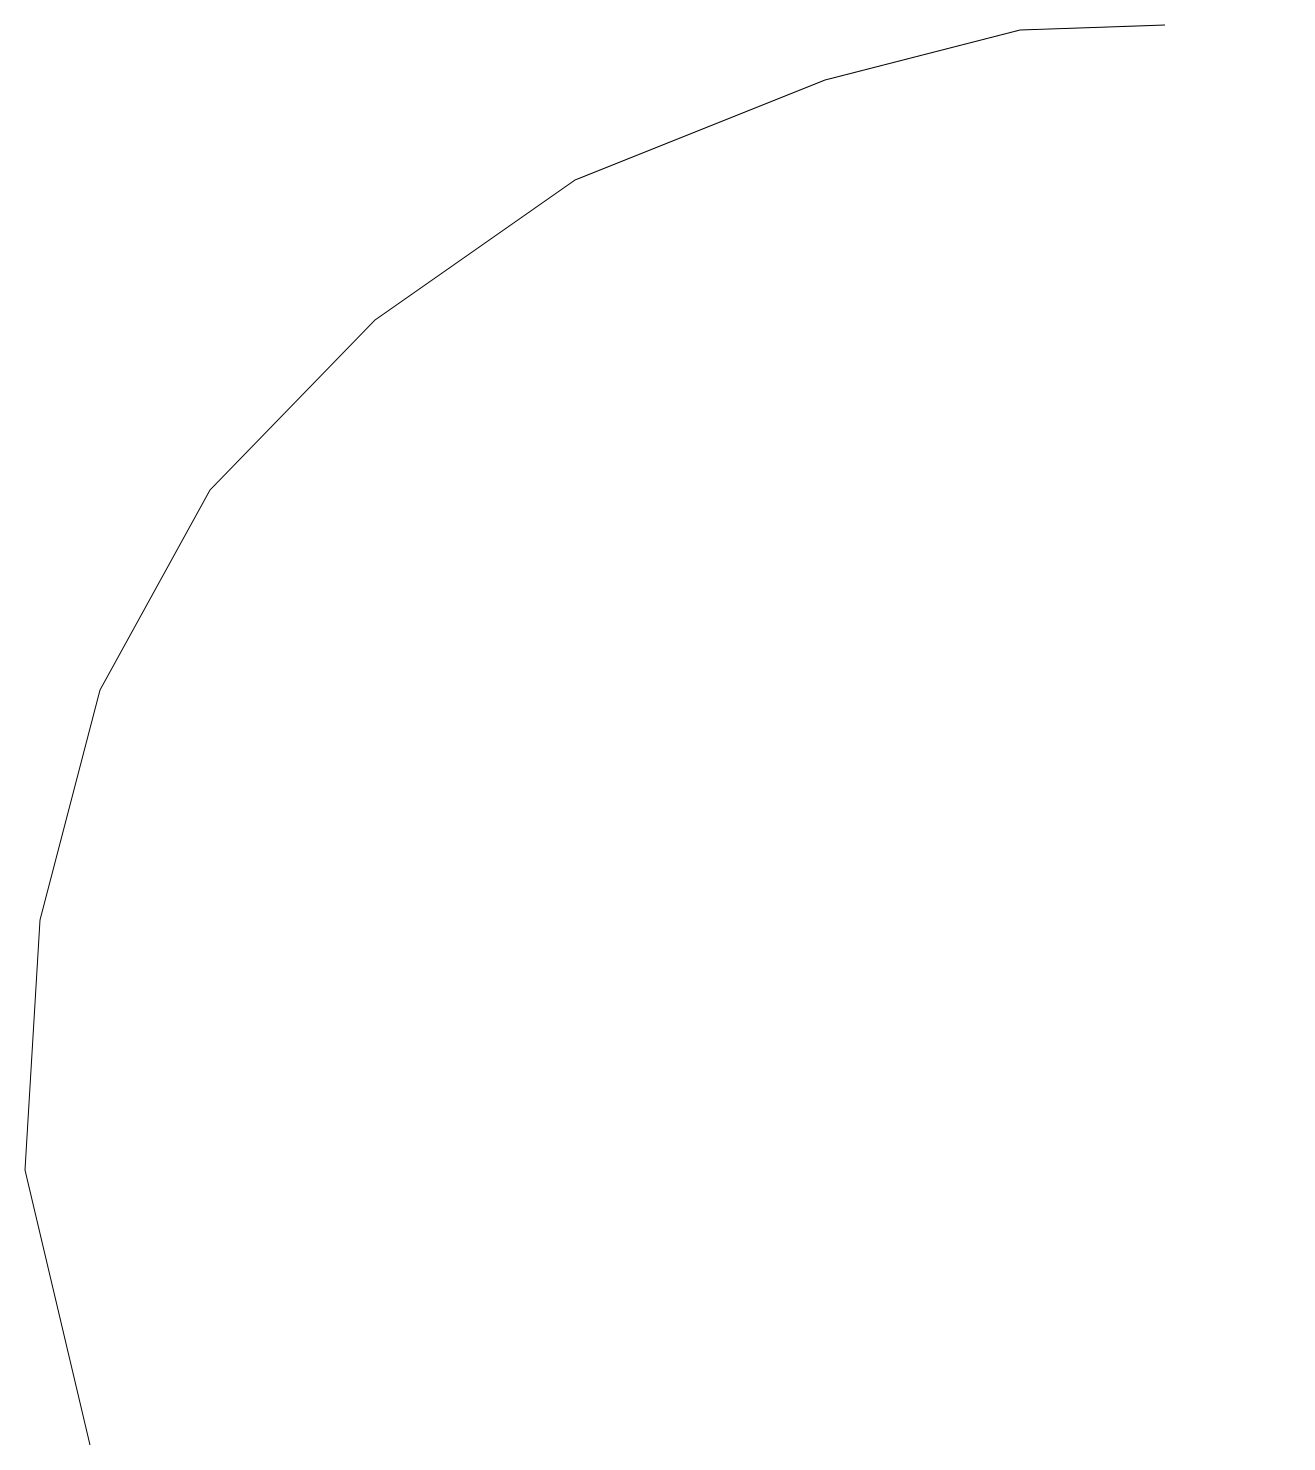

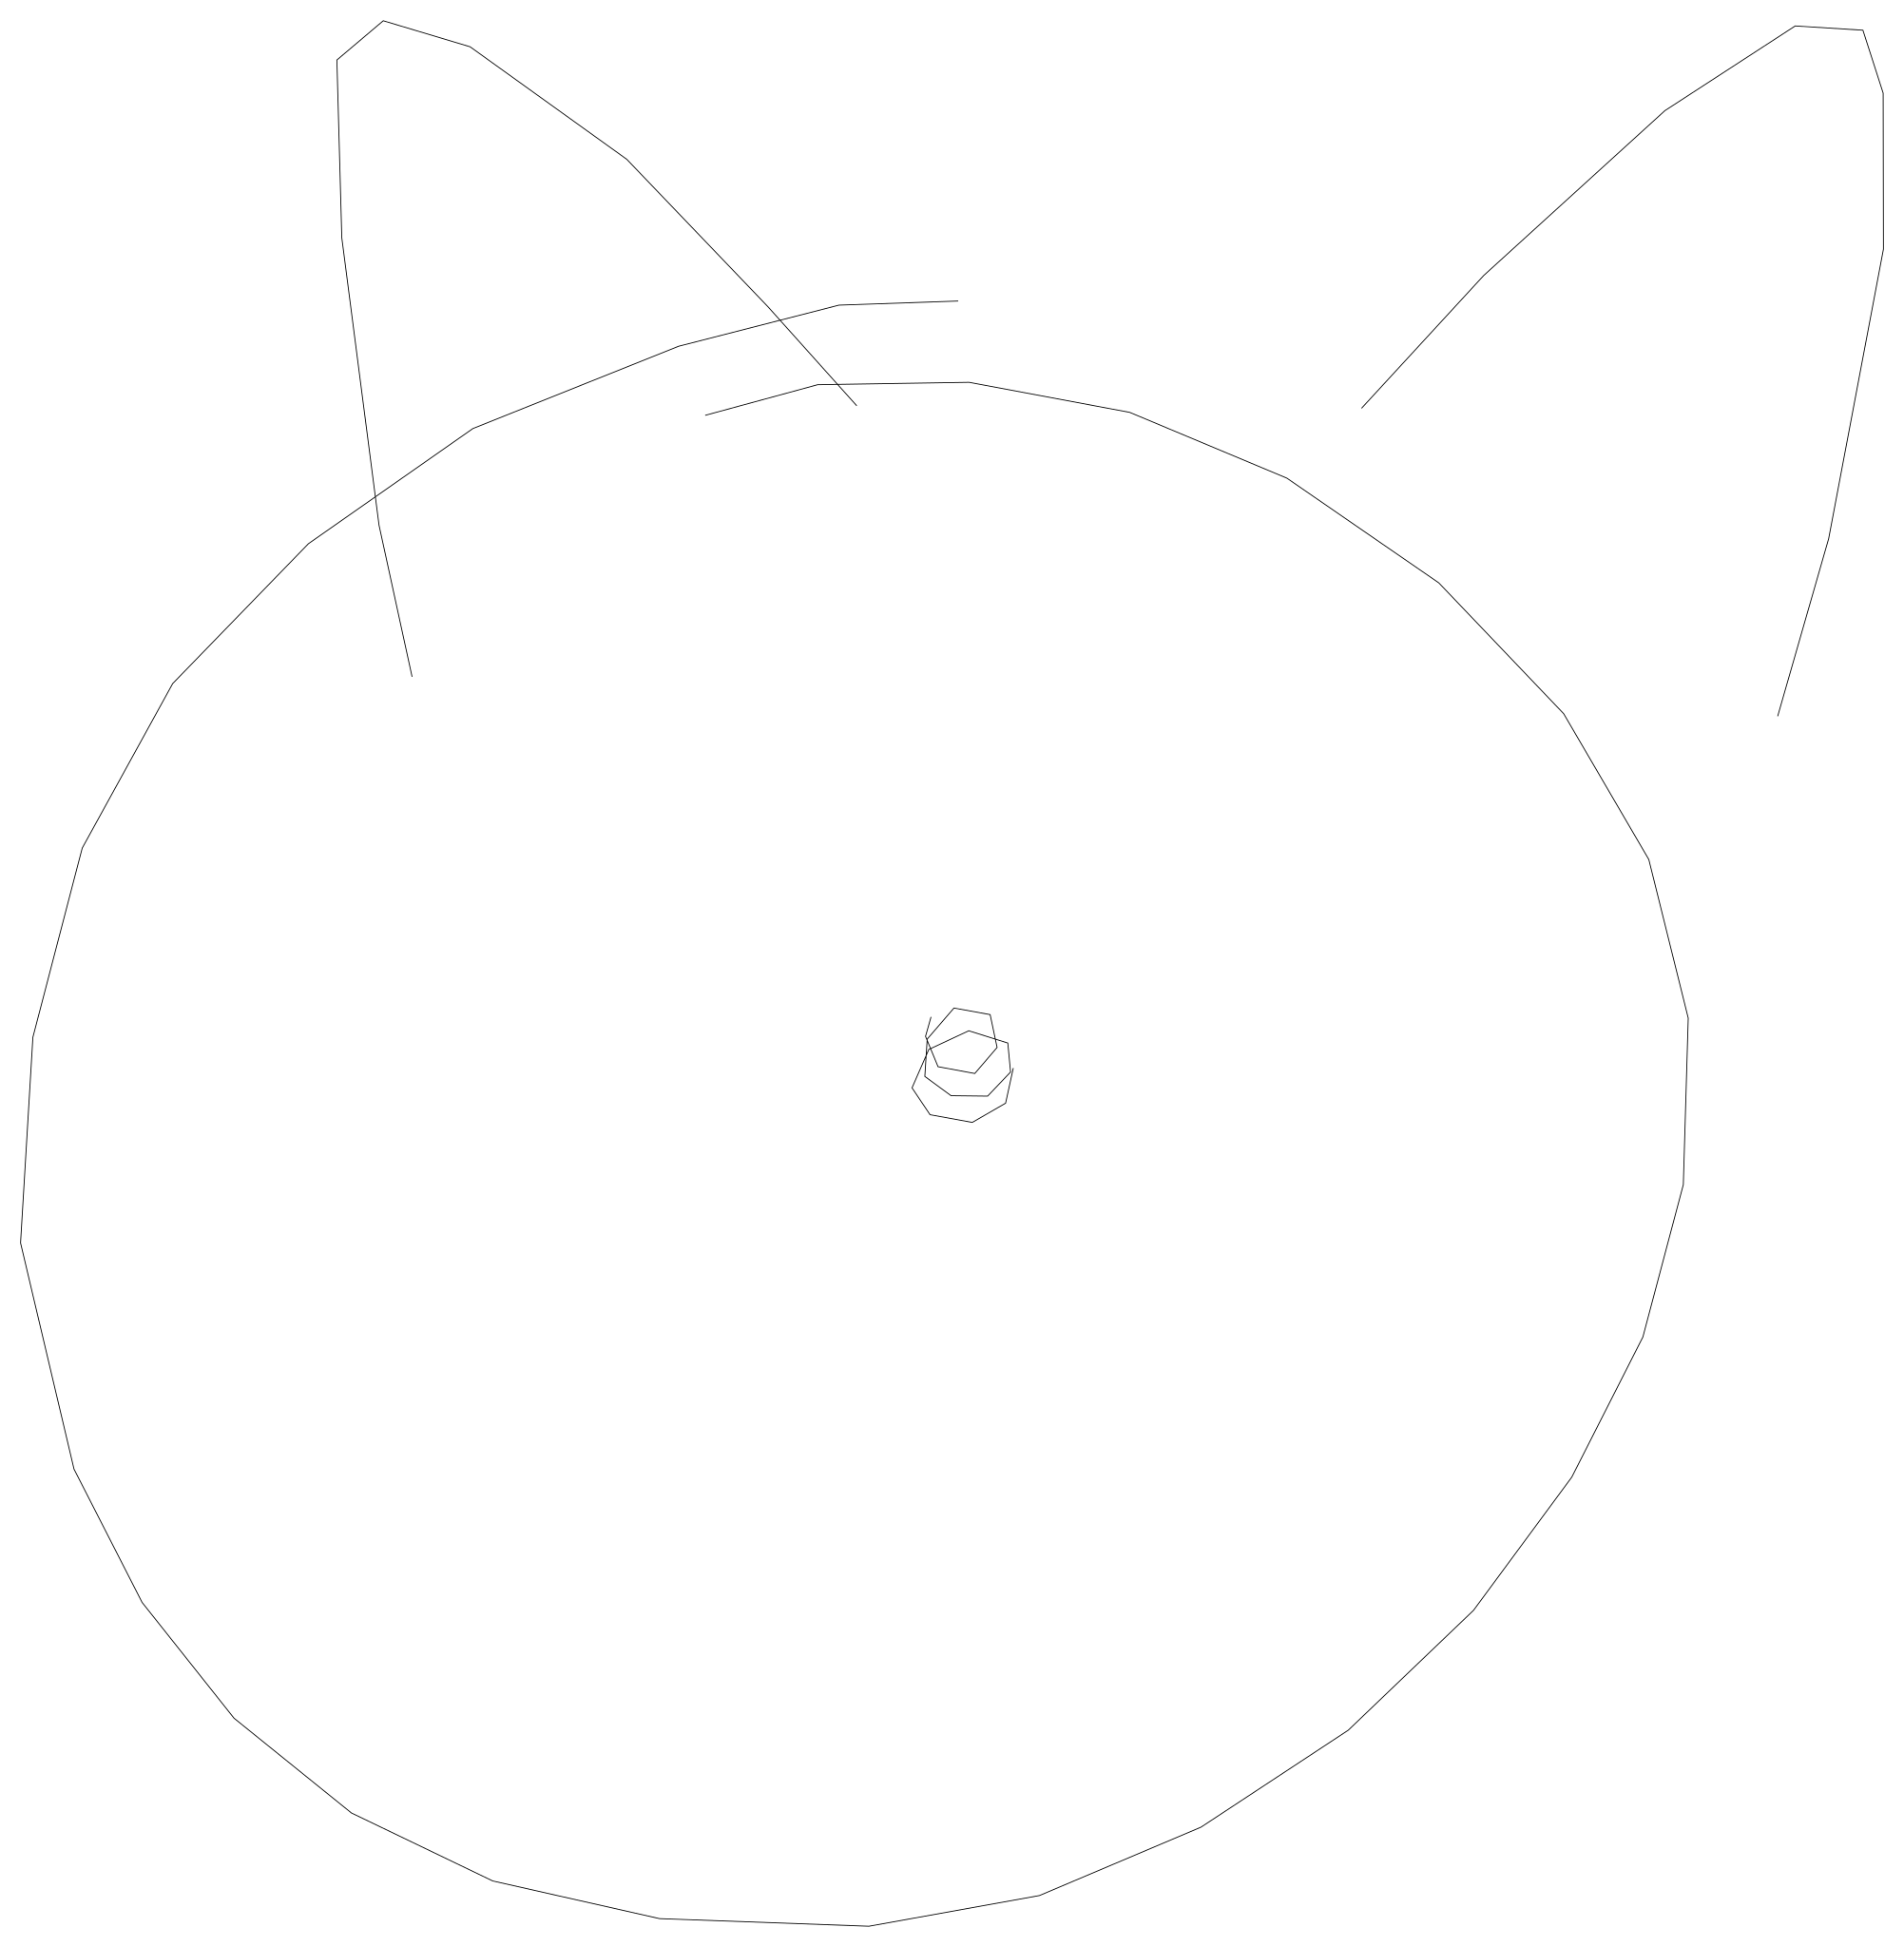

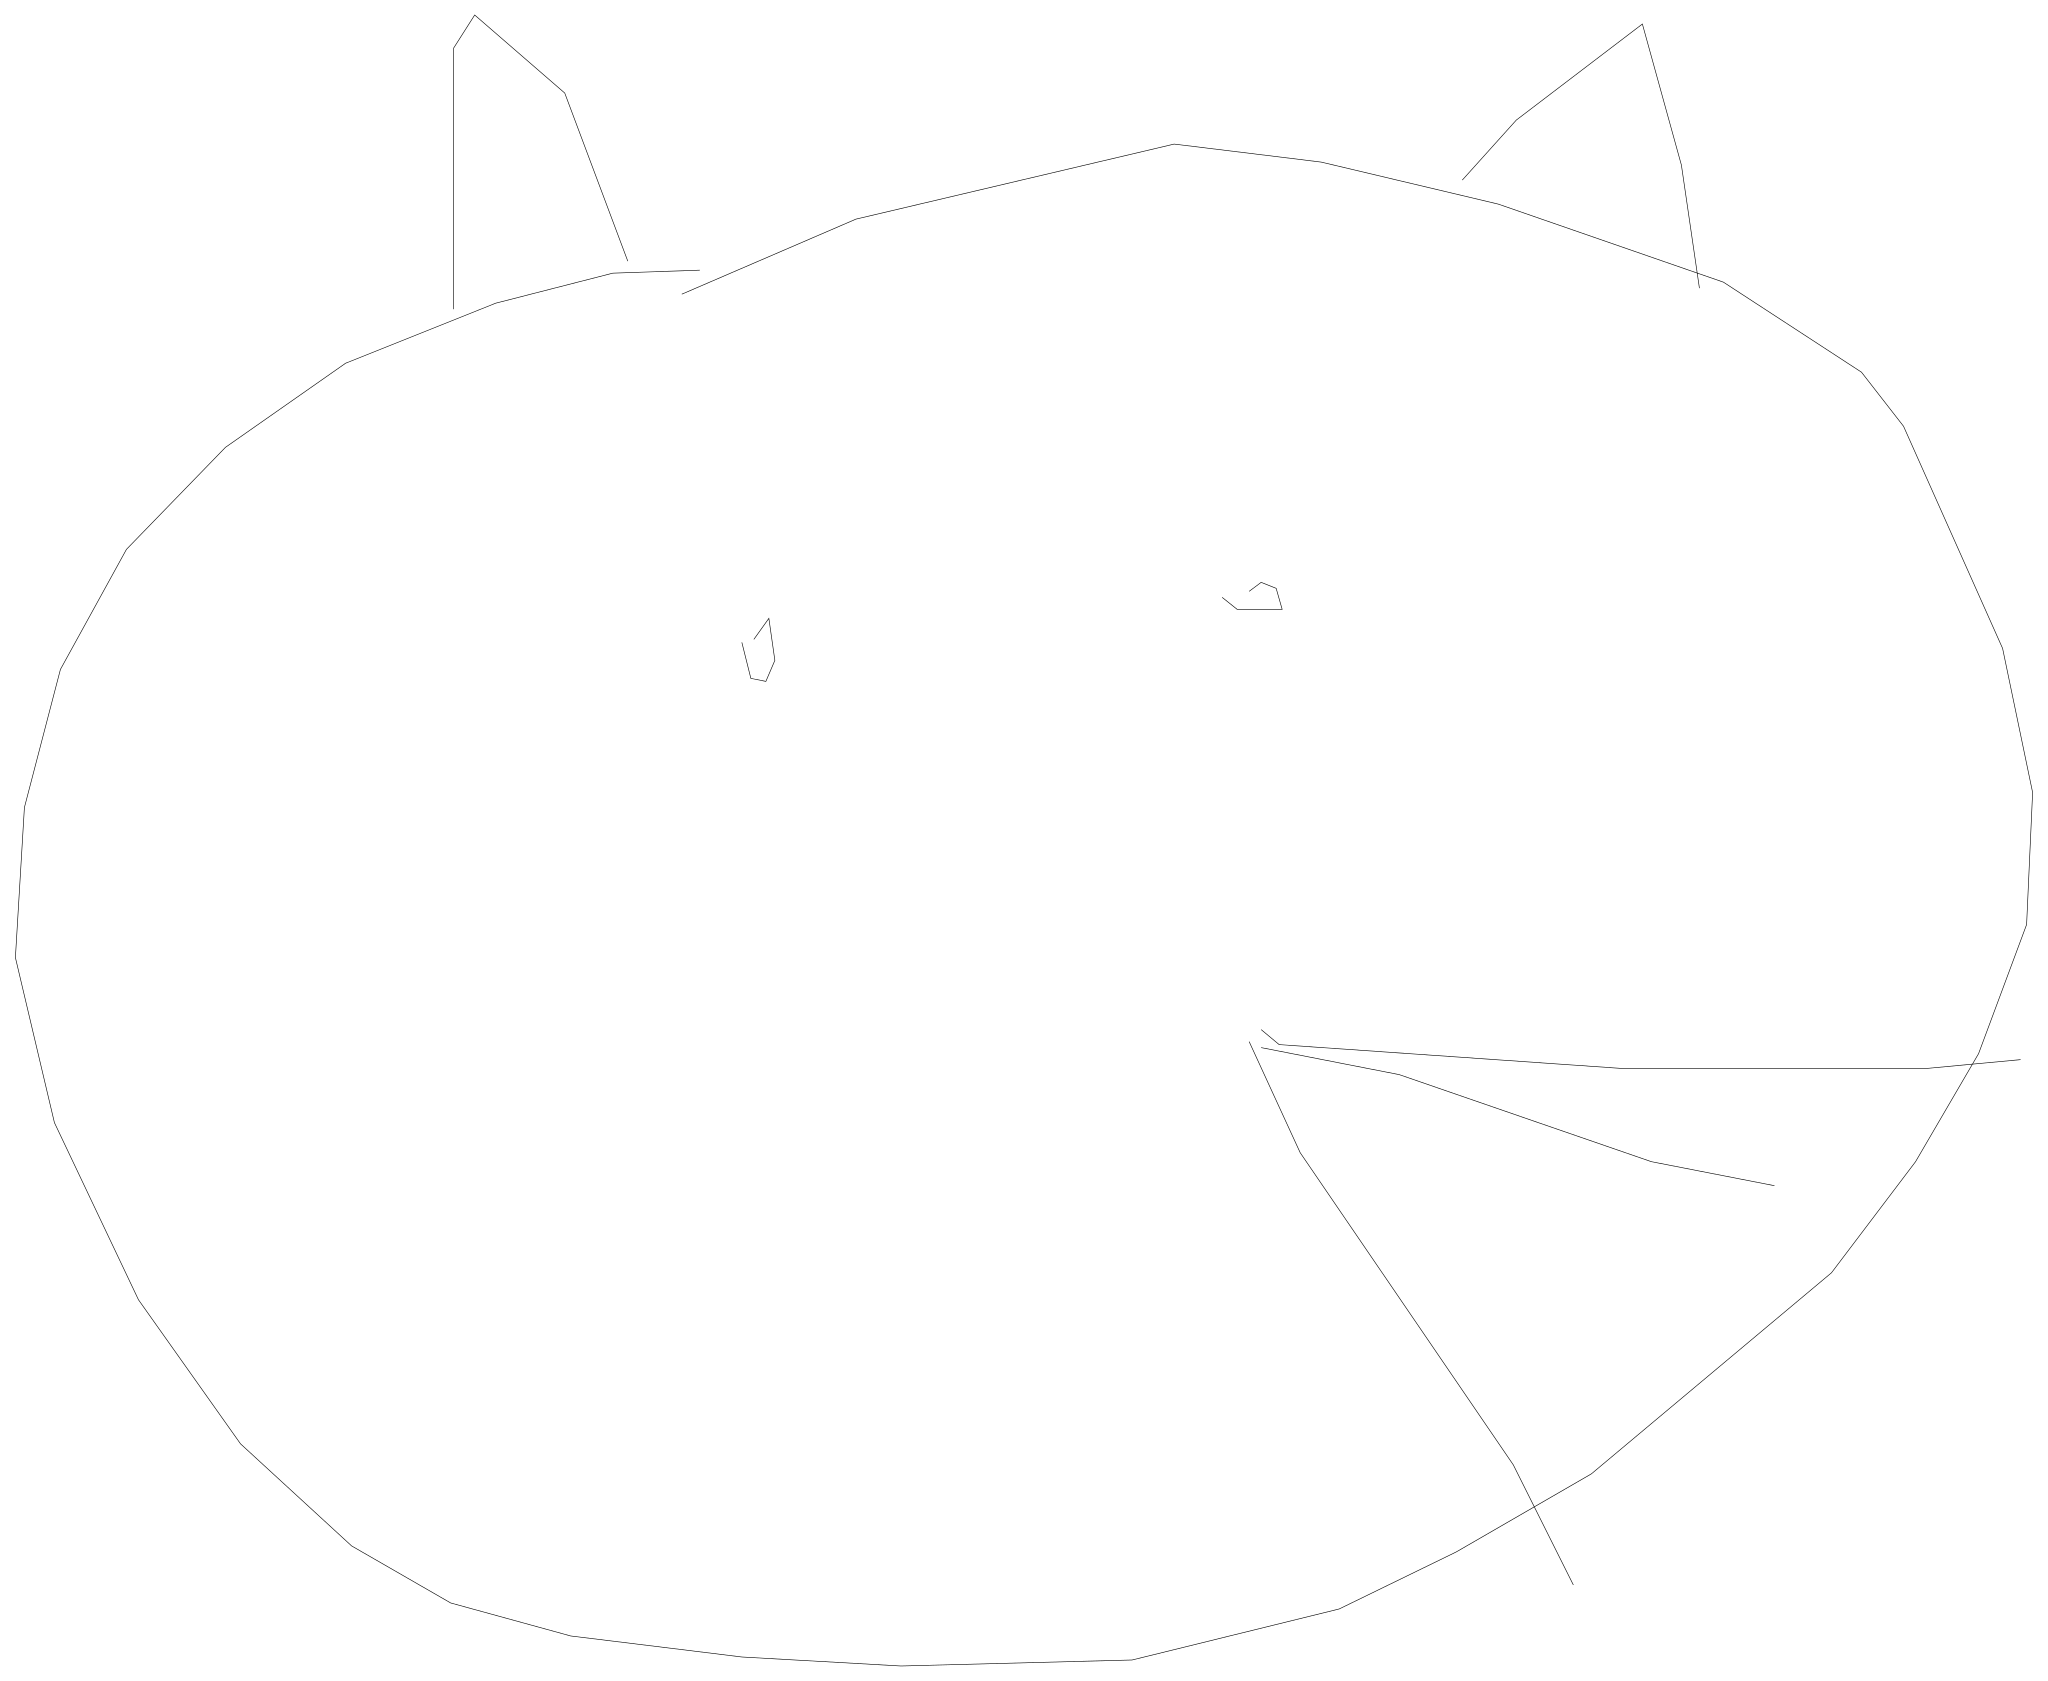

In [ ]:
from utils import draw_strokes

@torch.inference_mode()
def generate(model, input_seq):
    prev = input_seq
    
    i = 0
    while i < 60:
        offset, state = model.forward(prev)
        indices = torch.argmax(state, dim=-1)
        one_hot = torch.nn.functional.one_hot(indices, 3)
        pred = torch.cat((offset, one_hot), dim=-1)
        next_seg = pred[:, -1:, :]
        prev = torch.cat((prev, next_seg), dim=1)
        i += 1
    
    return prev

strokes = train_dataset[10][0]
i = (strokes[:10]).unsqueeze(0)

output_pred = generate(model, i.to("cuda")).cpu().numpy()[0]
output_actual = strokes[:70].numpy()
draw_strokes(i[0], svg_filename='./input.svg')
draw_strokes(output_pred, svg_filename='./sample.svg')
draw_strokes(output_actual, svg_filename='./actual.svg')